<a href="https://colab.research.google.com/github/tanynova99/neural_networks_course/blob/main/automated_cefr_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK for Lab4 "Финальный проект"

1. Вам предстоит самостоятельно поставить и решить некоторую прикладную задачу с применением нейронных сетей. Сложность и тип задачи вы выбираете сами, не обязательно, что бы задача касалась NLP. На максимальную оценку ваша задача должна быть сопоставима по сложности с последней лабой. Разрешается работать в парах. По итогу подразумевается, что у вас будет еще некоторая обертка (консольное приложение, тг-бот или что-то подобное) для обученной сетки.

1. После того, как вы сдадите работу, ее необходимо будет защитить на парах в марте. Во время защиты вы должны рассказать, что вы проделали, с какими проблемами столкнулись и как их решали. Учитывайте, что на защите вы можете даже слабый проект вытащить на хорошую оценку, если правильно его подадите.
Для тех, кто учится по мобильности и кто не сможет присутствовать на паре по уважительной причине, будет еще одна дистанционная защита (с датой решим позднее).

1. Отсутствие защиты - оценка по присланному ноутбуку минус 2 балла

*Это все дает вам максимальную оценку в 8 баллов. Для максимальной оценки вы должны дополнительно реализовать некоторую фичу из статьи, которую вы выбрали, и оценить ее полезность для вашей задачи. На защите у вас добавится 2-3 слайда о содержании статьи и 1 слайд об эффекте фичи в вашей работе. Если вы работаете в паре, то статьи у вас должно быть две.*

**Тайминг для защиты 7-10 минут + 5 минут вопросы**

> Мягкий дедлайн для сдачи ноутбука: 12.03 23:59
> Жёстий дедлайн: 14.03 23:59 со штафом по баллу в день

Сдавать сюда: https://forms.gle/we9MfzuwuFafdqYj8

# IMPORTS AND INSTALLATIONS

In [ ]:
# downloading data
from google.colab import drive
import zipfile

# handling data and modeling
import pandas as pd
import numpy as np

!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Flatten, LSTM, GRU, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# for text cleaning
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# for visualization
import matplotlib.pyplot as plt
import textwrap
import pprint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# TASK AT HAND

I decided to perform RNN training in order to classify CEFR tagged texts automatically. This taask is a first version of a project I'll work on within HSE laboratory.

# DATA

I downloaded and unzipped dataset of texts that have been assigned a CEFR level: https://www.kaggle.com/datasets/amontgomerie/cefr-levelled-english-texts

It's a very convenient datset for my purposes because it imitates what model has to do in the future

In [ ]:
# -u part controls extraction only if new/necessary
# -d creates the directory and extracted files are stored there
!unzip -u "/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/archive.zip" -d "/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/cerf_levelled"

df = pd.read_csv('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/cerf_levelled/cefr_leveled_texts.csv')
df.head(10)

Archive:  /content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/archive.zip


,text,label
0,Hi!\nI've been meaning to write for ages and f...,B2
1,﻿It was not so much how hard people found the ...,B2
2,Keith recently came back from a trip to Chicag...,B2
3,"The Griffith Observatory is a planetarium, and...",B2
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2
5,There can be different kinds of entertainment ...,B2
6,﻿Facebook has lost millions of users per month...,B2
7,Passover is a Jewish holiday that remembers an...,B2
8,Stephanie recently took a weekend trip to Los ...,B2
9,"-LSB- Breaking news alert, 6:23 a.m. GMT -LRB-...",B2


# PREPROCCESSING THE DATA

My preprocessing is copmrised of these steps:

- **Duplicates**.
- **Contractions removal**. I've read that it's easier for the model to understand things when words aren't contracted: are not instead of aren't etc. Therefore, I will do that. Level will still be analizeable, because the majority of CEFR English levels use contractions.
- **Punctuation removal**. I'll use constant called string.punctuation for it.
- **Split into words**. That's obvious, we need it for further vectorization, embeddings etc.
- **Removing stopwords**. Those are so basic that they do not denote any CEFR level.
- **Removal of whatever's left from prefious deletions**.

> Dealing with case of words is included in keras tokenizer

In [ ]:
# duplicates

df = df.drop_duplicates()

In [ ]:
def clean_text(txt):

    contraction_dict = {"ain't": "is not", "aren't": "are not", "'cause": "because",
                        "can't": "cannot", "could've": "could have", "couldn't": "could not",
                        "didn't": "did not",  "doesn't": "does not", "don't": "do not",
                        "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                        "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                        "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                        "I'll've": "I will have","I'm": "I am", "I've": "I have",
                        "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                        "i'll've": "i will have","i'm": "i am", "i've": "i have",
                        "isn't": "is not", "that's": "that is", "it'd": "it would",
                        "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                        "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                        "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                        "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                        "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                        "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                        "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                        "she's": "she is", "should've": "should have", "shouldn't": "should not",
                        "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                        "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                        "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                        "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                        "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                        "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                        "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                        "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                        "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                        "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                        "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                        "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                        "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                        "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                        "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)

    # remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)

    # split into words
    words = word_tokenize(txt)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # removing leftovers
    words = [word for word in words if word.isalpha()]

    cleaned_text = ' '.join(words)

    return cleaned_text

In [ ]:
tqdm.pandas()
df['clean_text'] = df['text'].progress_apply(lambda txt: clean_text(txt))

100%|██████████| 1494/1494 [00:05<00:00, 286.04it/s]


In [ ]:
df.head(10)

,text,label,clean_text
0,Hi!\nI've been meaning to write for ages and f...,B2,Hi I meaning write ages finally today I actual...
1,﻿It was not so much how hard people found the ...,B2,much hard people found challenge far would go ...
2,Keith recently came back from a trip to Chicag...,B2,Keith recently came back trip Chicago Illinois...
3,"The Griffith Observatory is a planetarium, and...",B2,The Griffith Observatory planetarium exhibit h...
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2,LRB The Hollywood Reporter RRB Its official AM...
5,There can be different kinds of entertainment ...,B2,There different kinds entertainment wedding re...
6,﻿Facebook has lost millions of users per month...,B2,lost millions users per month biggest markets ...
7,Passover is a Jewish holiday that remembers an...,B2,Passover Jewish holiday remembers celebrates l...
8,Stephanie recently took a weekend trip to Los ...,B2,Stephanie recently took weekend trip Los Angel...
9,"-LSB- Breaking news alert, 6:23 a.m. GMT -LRB-...",B2,LSB Breaking news alert GMT LRB ET RRB RSB Sco...


# EDA

In [ ]:
df['label'].unique()

array(['B2', 'A2', 'C1', 'B1', 'A1', 'C2'], dtype=object)

In [ ]:
df['label'].nunique() # the number of unique values

6

now let's encode them into numbers and see how balanced the set is

In [ ]:
labels_dict = {'A1': 0, 'A2' : 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
enc = LabelEncoder()
df['label'] = enc.fit_transform(df['label'])
df.head(10)

,text,label,clean_text
0,Hi!\nI've been meaning to write for ages and f...,3,Hi I meaning write ages finally today I actual...
1,﻿It was not so much how hard people found the ...,3,much hard people found challenge far would go ...
2,Keith recently came back from a trip to Chicag...,3,Keith recently came back trip Chicago Illinois...
3,"The Griffith Observatory is a planetarium, and...",3,The Griffith Observatory planetarium exhibit h...
4,-LRB- The Hollywood Reporter -RRB- It's offici...,3,LRB The Hollywood Reporter RRB Its official AM...
5,There can be different kinds of entertainment ...,3,There different kinds entertainment wedding re...
6,﻿Facebook has lost millions of users per month...,3,lost millions users per month biggest markets ...
7,Passover is a Jewish holiday that remembers an...,3,Passover Jewish holiday remembers celebrates l...
8,Stephanie recently took a weekend trip to Los ...,3,Stephanie recently took weekend trip Los Angel...
9,"-LSB- Breaking news alert, 6:23 a.m. GMT -LRB-...",3,LSB Breaking news alert GMT LRB ET RRB RSB Sco...


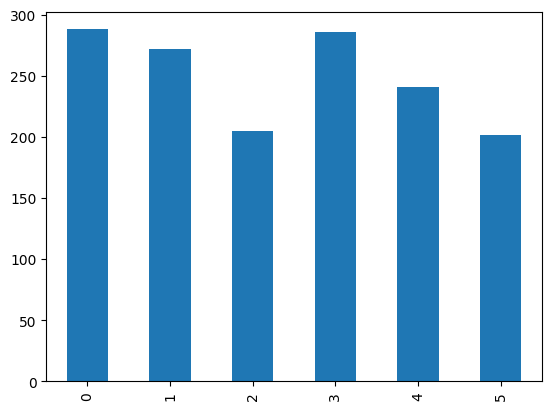

In [ ]:
df['label'].sort_values().value_counts(sort=False).plot.bar(legend=False)
plt.show()

- train and split with max text length
- max_len is needed for embeddings

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], random_state=42, shuffle=True, test_size=0.3)

# find the length of the largest sentence in training data
max_len = x_train.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 7284


# TOKENIZER & EMBEDDINGS

**Tokenizer in Keras** finds the frequency of each unique word and sort them based on their frequency. It then assigns an integer value starting from 1 to each word from the top. You can see the index mapping dictionary by reading tokenizer.word_index.

Since I need to analyze the texts from A1 to C2 levels, I will set a high number of max words in the vocabulary.

In [ ]:
max_words = 18000
tokenizer = text.Tokenizer(num_words = max_words)

# create the vocabulary
tokenizer.fit_on_texts(x_train)

# generate sequences of tokens
x_train_sequence = tokenizer.texts_to_sequences(x_train)
x_test_sequence = tokenizer.texts_to_sequences(x_test)

# pad the sequences
#x_train_padded = sequence.pad_sequences(x_train_sequence, maxlen=max_len, padding='post')
#x_test_padded = sequence.pad_sequences(x_test_sequence, maxlen=max_len, padding='post')

x_train_padded = sequence.pad_sequences(x_train_sequence, maxlen=max_len)
x_test_padded = sequence.pad_sequences(x_test_sequence, maxlen=max_len)

word_index = tokenizer.word_index

In [ ]:
print('text:', x_train)
print()
print('before padding:', x_train_sequence)
print()
print('after padding:', x_train_padded)

text: 500     Going allboy high school fun Joes parents thou...
737     Russell Crowe born New Zealand musician actor ...
486     Rocky big baseball fan He lived Philadelphia o...
493     Frank moved apartment small house family When ...
10      Countries rarely default least basic understan...
                              ...                        
1130    I like way sang tonight Oh wow Well thanks com...
1294    Taliban militants implemented Islamic law Paki...
860     Taxes special fees charged government people l...
1459    morning temperatures India capital start rise ...
1126    Alice told son Jesse go room He want go room W...
Name: clean_text, Length: 1045, dtype: object

before padding: [[43, 14971, 153, 55, 809, 8969, 172, 122, 7, 59, 403, 905, 408, 136, 55, 4, 7, 22, 6677, 704, 200, 7, 83, 1041, 404, 34, 1137, 14972, 200, 350, 29, 136, 55, 2, 53, 1533, 7, 437, 2, 53, 482, 704, 2, 53, 3451, 21, 862, 84, 810, 8970, 5945, 200, 84, 3, 1137, 2595, 14, 29, 2882, 153, 55, 380, 53

- Using word embedding through **GloVe**, we can have a decent performance with models with even relatively small label training sets.
- You can download GloVe pre-trained word vectors from the link below. https://nlp.stanford.edu/projects/glove/

In [ ]:
embedding_vectors = {}

with open('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/glove.6B.50d.txt','r',encoding='utf-8') as file:
    for row in tqdm(file):
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights

print(f"\nSize of vocabulary in GloVe: {len(embedding_vectors)}")

400000it [00:12, 33198.02it/s]


Size of vocabulary in GloVe: 400000


In [ ]:
# initialize the embedding_matrix with zeros
emb_dim = 50

if max_words is not None:
    vocab_len = max_words
else:
    vocab_len = len(word_index)+1

embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []

for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)

# print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['yearold', 'cnns', 'alassad', 'samesex', 'ciancia']


In [ ]:
embedding_matrix.shape

(18000, 50)

In [ ]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

1252 out of 18000 words were OOV.


# RNN ARCHITECHTURE

I was thinking how my model should look like and I settled on LSTM. RNNs are usually better performing, LSTM is... uh just cause, RNN is not as good.

In Keras, when you define a Long Short-Term Memory (LSTM) layer with return_sequences=True, it means that the LSTM layer will return the full sequence of outputs for each input sequence. This is useful when you're stacking LSTM layers or when you want to connect the LSTM layer to another recurrent layer.

On the other hand, when return_sequences=False, the LSTM layer will only return the output of the last time step, effectively collapsing the sequence dimension and returning only the final output for each input sequence. This is commonly used when the LSTM layer is followed by a non-recurrent layer such as a Dense layer, or when you're using the LSTM for sequence classification tasks where you only need the final prediction.

In [ ]:
lstm_model = Sequential()

lstm_model.reset_states()

lstm_model.add(Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable = True))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(6, activation = 'softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          900000    
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1000294 (3.82 MB)
Trainable params: 1000294 (3.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# TRAINING

In [ ]:
batch_size = 256
epochs  = 30

history = lstm_model.fit(x_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=.2)

Epoch 1/30
4/4 [==============================] - 6s 734ms/step - loss: 1.7912 - accuracy: 0.1722 - val_loss: 1.7889 - val_accuracy: 0.2057
Epoch 2/30
4/4 [==============================] - 3s 685ms/step - loss: 1.7842 - accuracy: 0.2919 - val_loss: 1.7834 - val_accuracy: 0.2919
Epoch 3/30
4/4 [==============================] - 2s 538ms/step - loss: 1.7721 - accuracy: 0.3242 - val_loss: 1.7702 - val_accuracy: 0.2871
Epoch 4/30
4/4 [==============================] - 2s 587ms/step - loss: 1.7498 - accuracy: 0.2177 - val_loss: 1.7475 - val_accuracy: 0.3589
Epoch 5/30
4/4 [==============================] - 2s 543ms/step - loss: 1.7041 - accuracy: 0.3804 - val_loss: 1.6348 - val_accuracy: 0.2440
Epoch 6/30
4/4 [==============================] - 2s 593ms/step - loss: 1.6218 - accuracy: 0.4701 - val_loss: 1.7055 - val_accuracy: 0.2967
Epoch 7/30
4/4 [==============================] - 2s 625ms/step - loss: 1.6352 - accuracy: 0.6555 - val_loss: 1.6755 - val_accuracy: 0.3349
Epoch 8/30
4/4 [====

# EVALUATION

Text(0.5, 1.0, 'Accuracy')

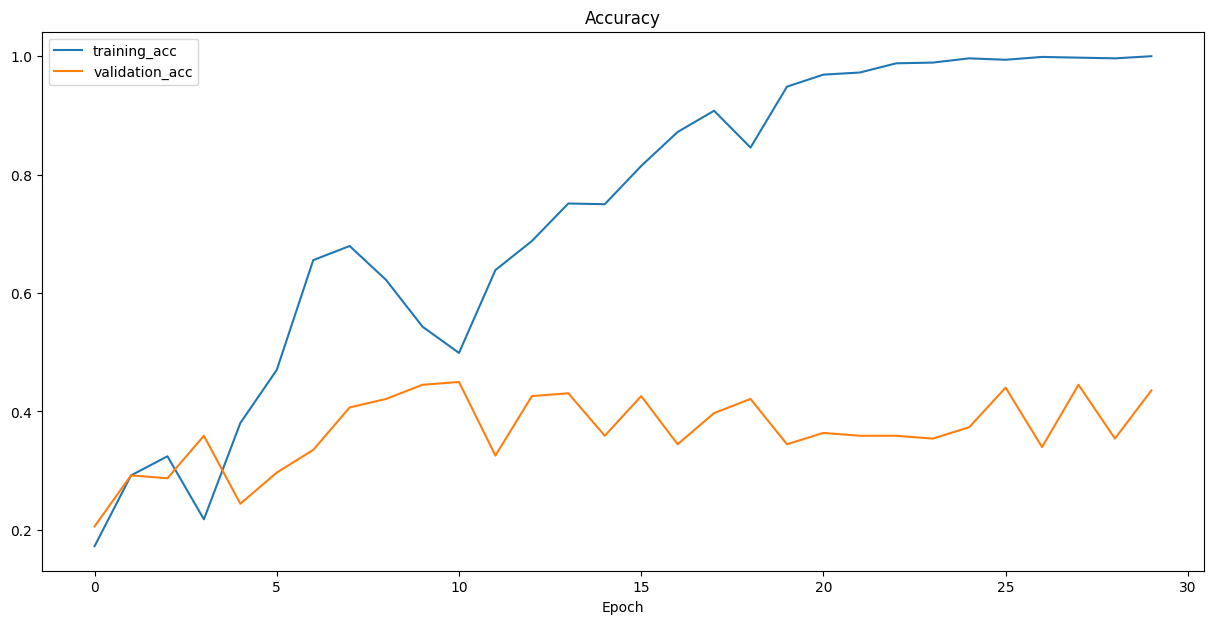

In [ ]:
#plot accuracy

plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy')

In [ ]:
# prediction on test sample

y_predict = lstm_model.predict(x_test_padded)
prediction = np.argmax(y_predict, axis=1)

# report of the prediction

print(classification_report(y_test, prediction))

15/15 [==============================] - 2s 84ms/step
              precision    recall  f1-score   support

           0       0.73      0.87      0.80        95
           1       0.69      0.47      0.56        88
           2       0.17      0.33      0.23        60
           3       0.32      0.35      0.33        78
           4       0.41      0.37      0.39        65
           5       0.94      0.27      0.42        63

    accuracy                           0.47       449
   macro avg       0.55      0.44      0.45       449
weighted avg       0.56      0.47      0.48       449



https://medium.com/@megha.natarajan/understanding-the-intuition-behind-classification-report-metrics-macro-average-vs-d9c2cc04717d#:~:text=The%20weighted%20average%20takes%20into,of%20classes%20with%20more%20instances.

# SOLUTION PROPOSED BY AN ARTICLE

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9668927

A Deep Bidirectional LSTM-GRU Network Model for Automated Ciphertext Classification

> I LEFT MY SIZE OF EMBEDDINGS because I was only compairing architectures themselves

In [ ]:
blstm_gru_model = Sequential()

blstm_gru_model.reset_states()

blstm_gru_model.add(Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False, input_shape=(max_len,)))
blstm_gru_model.add(Bidirectional(LSTM(50, return_sequences=True)))
blstm_gru_model.add(Dropout(0.2))
blstm_gru_model.add(GRU(50, return_sequences=True))
blstm_gru_model.add(Dropout(0.2))
blstm_gru_model.add(LSTM(50, return_sequences=True))
blstm_gru_model.add(Dropout(0.2))
blstm_gru_model.add(Flatten())
blstm_gru_model.add(Dense(15))
blstm_gru_model.add(Dense(6, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
blstm_gru_model.compile(loss='sparse_categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
print(blstm_gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 7284, 50)          900000    
                                                                 
 bidirectional (Bidirection  (None, 7284, 100)         40400     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 7284, 100)         0         
                                                                 
 gru (GRU)                   (None, 7284, 50)          22800     
                                                                 
 dropout_1 (Dropout)         (None, 7284, 50)          0         
                                                                 
 lstm_2 (LSTM)               (None, 7284, 50)          20200     
                                                      

In [ ]:
batch_size = 128
epochs  = 100

history_blstm = blstm_gru_model.fit(x_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=.2)

Epoch 1/100
7/7 [==============================] - 25s 1s/step - loss: 3.7041 - accuracy: 0.1866 - val_loss: 2.1197 - val_accuracy: 0.1866
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 2.2616 - accuracy: 0.1687 - val_loss: 1.7519 - val_accuracy: 0.4306
Epoch 3/100
7/7 [==============================] - 7s 1s/step - loss: 1.7996 - accuracy: 0.2715 - val_loss: 1.6012 - val_accuracy: 0.3828
Epoch 4/100
7/7 [==============================] - 8s 1s/step - loss: 1.6699 - accuracy: 0.3074 - val_loss: 1.5896 - val_accuracy: 0.3445
Epoch 5/100
7/7 [==============================] - 7s 1s/step - loss: 1.6229 - accuracy: 0.2895 - val_loss: 1.5704 - val_accuracy: 0.2488
Epoch 6/100
7/7 [==============================] - 7s 1s/step - loss: 1.4986 - accuracy: 0.3577 - val_loss: 1.4354 - val_accuracy: 0.3445
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 1.4285 - accuracy: 0.3995 - val_loss: 1.3314 - val_accuracy: 0.4354
Epoch 8/100
7/7 [================

Text(0.5, 1.0, 'Accuracy')

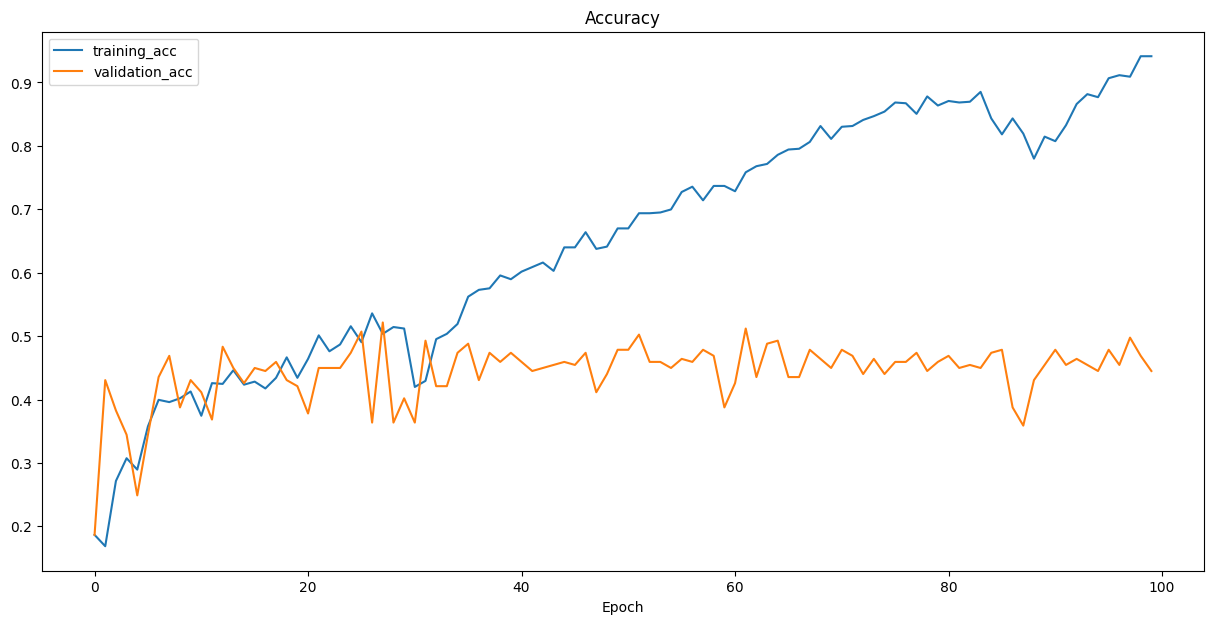

In [ ]:
#plot accuracy

plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history_blstm.history['accuracy'])
plt.plot(range(epochs), history_blstm.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.xlabel('Epoch')
plt.title('Accuracy')

In [ ]:
# prediction on test sample

y_predict_blstm = blstm_gru_model.predict(x_test_padded)
prediction_blstm = np.argmax(y_predict_blstm, axis=1)

# report of the prediction

print(classification_report(y_test, prediction_blstm))

15/15 [==============================] - 7s 345ms/step
              precision    recall  f1-score   support

           0       0.67      0.79      0.72        95
           1       0.40      0.41      0.41        88
           2       0.15      0.15      0.15        60
           3       0.26      0.26      0.26        78
           4       0.26      0.28      0.27        65
           5       0.37      0.24      0.29        63

    accuracy                           0.39       449
   macro avg       0.35      0.35      0.35       449
weighted avg       0.38      0.39      0.38       449



# SAVING BOTH PRETRAINED MODELS FOR FURTHER USE + PREDICTION

> you can run imports and that section and that's it, you have a working model without painful hours of retraining

In [ ]:
# save the entire models as a `.keras` zip archive. - i did it right after each model was trained
lstm_model.save('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/my_lstm_model.keras')
blstm_gru_model.save('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/my_blstm_gru_model.keras')

Reload a fresh Keras model from the `.keras` zip archive:

In [ ]:
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/my_lstm_model.keras')
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/4/my_blstm_gru_model.keras')

try predict with the loaded model:

In [ ]:
def get_key_from_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None

In [ ]:
def classify_input_saved(input_text):

    labels_dict = {'A1': 0, 'A2' : 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}

    # preprocess input
    input_sequence = tokenizer.texts_to_sequences(input_text)
    input_padded = sequence.pad_sequences(input_sequence, maxlen=max_len)

    # make prediction
    prediction_1 = model_1.predict(input_padded)
    prediction_2 = model_2.predict(input_padded)

    # convert prediction to class label indices
    p_1 = []
    p_2 = []

    for i in range(len(input_text)):

      class_label_1 = prediction_1[i].argmax()
      p_1.append(class_label_1)

      class_label_2 = prediction_2[i].argmax()
      p_2.append(class_label_2)

    p_1 = max(p_1)
    p_2 = max(p_2)

    return [get_key_from_value(labels_dict, p_1),
            get_key_from_value(labels_dict, p_2)]

In [ ]:
inpt = input("your input: ")
print("predicted class:", classify_input_saved(inpt))

your input: teddy bear 
1/1 [==============================] - 0s 376ms/step
predicted class: ['A1', 'A1']


# CONCLUSION

- I used first architechture because I assumed RNNs work well with texts and it's a mode difficult architechture.

- The second model was picked mainly because it implemented similar structures, e.g. BiLSTM and GRU. I was interested to know whether they will work better or not.

- *However, I had to downsize the number of neurons in every layer 4 times because of Colab restrictions. Additionally, I added a Flatten() layer because it wouldn't work otherwise.*

- In order to make comparison fairer, I left the first layer the same.

- The main structural differences are: i. number of layers; ii. number of types of layers;

- It's hard to say which model preforms better:

1.  The predictions (raw) are generally bigger with the second model, e.g., prediction from model 1 gives 6 classes: 0.0002, 0.000003, 0.00008 etc. Model 2 gives out predictions like 0.7987, 0.04566 etc.

2. The first model runs faster, although both are time consuming: 1h and 1,5 hrs respectively. (with free CPU unit)

3. Due to higher f1 score of A1 level (label 0) everything detects as A1 😞

**I was able to run the second model with T4 CPU for a short period of time, with around 100 epochs accuracy got reasonabler. I ran 100 epochs with 128 batch and 64 batch. 64 gave lower val_loss.**

**It's opened to discussion as to how both models respond to class weights, similar learning rates, undersampling etc.**